In [1]:
#Tạo đường dẫn chung để đọc utils
import sys
import os

# Lên 2 cấp thư mục để tới thư mục gốc (từ data/LichSuDang/ về RAG_GeneralSubject/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

print(f"Đã thêm đường dẫn: {project_root}")
print(f"Thư mục hiện tại: {os.getcwd()}")

Đã thêm đường dẫn: d:\Documents\TDTU\Kiến tập\RAG_GeneralSubject
Thư mục hiện tại: d:\Documents\TDTU\Kiến tập\RAG_GeneralSubject\data\LichSuDang


In [2]:
# PDF parsing
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTTextLine, LTChar
from pypdf import PdfReader

# Text processing
from langchain.text_splitter import RecursiveCharacterTextSplitter
import re
import unicodedata
import json
import os

# Embedding & Vector search
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import torch
import numpy as np

In [3]:
# Utils
from utils.load_chunks_json import load_chunks_from_json
from utils.save_chunks_json import save_chunks_to_json
from utils.bm25 import bm25_tokenize, text_to_sparse_vector_bm25

# ***Tạo hàm xử lý các chunk***

In [4]:
def parse_chapters(text):
    """
    Phân tích 1 dòng chương/tiêu đề, hỗ trợ các định dạng:
    - 'Chương 1 Tiêu đề...'
    - 'Chương nhập môn Tiêu đề...'
    - 'I. Tiêu đề...'
    - '1. Tiêu đề...'

    Trả về tuple: (chapter_number, chapter_title)
    Nếu không khớp format, trả về (, )
    """
    pattern = re.compile(
        r"""^\s*
        (                                         # Nhóm 1: định danh chương
            Chương\s+(?:nhập\s+môn|\d+)           # 'Chương nhập môn' hoặc 'Chương <số>'
            |[IVXLCDM]+\.                         # Số La Mã có dấu chấm (I., II., ...)
            |\d+\.?                                # Số thường, có thể có hoặc không dấu chấm
        )
        \s*(.*)                                    # Nhóm 2: tiêu đề còn lại
        """, re.IGNORECASE | re.VERBOSE
    )
    
    line = text.strip()
    match = pattern.match(line)
    if match:
        chapter_number = match.group(1).strip().rstrip('.') or ""
        chapter_title = match.group(2).strip() or ""

        if (chapter_number and len(chapter_number) > 1) or (chapter_title and len(chapter_title) > 1):
            return chapter_number, chapter_title
        else:
            return "", text
    else:
        return "", text


In [5]:
def normalize_text(text):
    """
    Chuyển chuỗi thành lowercase, xóa dấu, và xóa toàn bộ khoảng trắng.
    """
    # Lowercase
    text = text.lower()

    # Bỏ dấu
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # Xóa toàn bộ khoảng trắng (space, tab, newline)
    text = re.sub(r'\s+', '', text)

    return text

In [6]:
# Hàm dùng để chuyển đổi data từ RAW chunks sang Dense Chunks
def raw_to_dense_chunk(
    chapter_line,
    section_line,
    sub_section_line,
    content_line,
    max_chars=2048,
    model=None,
    global_chunk_counter=None  # Thêm tham số để đảm bảo unique ID
):

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chars,
        chunk_overlap=300,  
        separators=["\n\n", "\n", ".", " ", ""]
    )
    content_chunks = splitter.split_text(content_line)

    # Xử lý metadata như cũ
    chapter_number, chapter_title = parse_chapters(chapter_line) if chapter_line else ("", "")
    section_number, section_title = parse_chapters(section_line) if section_line else ("", "")
    subsection_number, subsection_title = parse_chapters(sub_section_line) if sub_section_line else ("", "")

    if 'MỤC TIÊU' in section_line:
        chunk_type = 'TARGET'
    elif 'NỘI DUNG ÔN TẬP VÀ THẢO LUẬN' in section_line:
        chunk_type = 'EXERCISES'
    else:
        chunk_type = 'THEORY'

    result = []
    for i, content_piece in enumerate(content_chunks):
        content = content_piece.strip()
        
        # Tạo ID unique bằng cách sử dụng global counter
        if global_chunk_counter is not None:
            # Sử dụng global counter để đảm bảo hoàn toàn unique
            unique_id = f"LSD_chunk_{global_chunk_counter['count']:05d}"
            global_chunk_counter['count'] += 1
        else:
            # Fallback về cách cũ nếu không có global counter
            unique_id = f"LSD_{normalize_text(chapter_number) if chapter_number else 'unknown'}_{section_number if section_number else 0}_{subsection_number if subsection_number else 0}_{i}"
        
        chunk = {
            "id": unique_id,
            "values": model.encode(content).tolist(),
            "metadata": {
                "subject": "Lịch sử Đảng Cộng Sản Việt Nam",
                "chapter": chapter_number,
                "chapter_title": chapter_title,
                "section": section_number,
                "section_title": section_title,
                "subsection": subsection_number,
                "subsection_title": subsection_title,
                "content": content,
                "tokens": len(content_piece),
                "type": chunk_type,
                # Thêm thông tin để debug nếu cần
                "original_structure": f"{chapter_number}_{section_number}_{subsection_number}_{i}"
            }
        }
        result.append(chunk)

    return result

In [7]:
# Hàm dùng để chuyển đổi data từ RAW chunks sang Sparse Chunks
def raw_to_sparse_chunk(
    chapter_line,
    section_line,
    sub_section_line,
    content_line,
    bm25=None,
    vocabulary=None,
    max_chars=2048,
    global_chunk_counter=None  # Thêm tham số để đảm bảo unique ID
):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chars,
        chunk_overlap=300,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    content_chunks = splitter.split_text(content_line)

    # Metadata parsing
    chapter_number, chapter_title = parse_chapters(chapter_line) if chapter_line else ("", "")
    section_number, section_title = parse_chapters(section_line) if section_line else ("", "")
    subsection_number, subsection_title = parse_chapters(sub_section_line) if sub_section_line else ("", "")

    if 'MỤC TIÊU' in section_line:
        chunk_type = 'TARGET'
    elif 'NỘI DUNG ÔN TẬP VÀ THẢO LUẬN' in section_line:
        chunk_type = 'EXERCISES'
    else:
        chunk_type = 'THEORY'

    result = []
    for i, content_piece in enumerate(content_chunks):
        content = content_piece.strip()
        sparse_vector = text_to_sparse_vector_bm25(content, bm25, vocabulary)

        # Tạo ID unique bằng cách sử dụng global counter
        if global_chunk_counter is not None:
            # Sử dụng global counter để đảm bảo hoàn toàn unique
            unique_id = f"LSD_chunk_{global_chunk_counter['count']:05d}"
            global_chunk_counter['count'] += 1
        else:
            # Fallback về cách cũ nếu không có global counter
            unique_id = f"LSD_{normalize_text(chapter_number) if chapter_number else 'unknown'}_{section_number if section_number else 0}_{subsection_number if subsection_number else 0}_{i}"

        chunk = {
            "id": unique_id,
            "values":[],
            "sparse_values": sparse_vector,
            "metadata": {
                "subject": "Lịch sử Đảng Cộng Sản Việt Nam",
                "chapter": chapter_number,
                "chapter_title": chapter_title,
                "section": section_number,
                "section_title": section_title,
                "subsection": subsection_number,
                "subsection_title": subsection_title,
                "content": content,
                "tokens": len(content_piece),
                "type": chunk_type,
                # Thêm thông tin để debug nếu cần
                "original_structure": f"{chapter_number}_{section_number}_{subsection_number}_{i}"
            }
        }
        result.append(chunk)

    return result

In [8]:
def extract_raw_chunks_LSD(pdf_path, total_pages):
    """
    Trích xuất các đoạn nội dung theo chương - mục - mục con mà chưa split theo embedding.
    Trả về danh sách các dict: {"chapter": ..., "section": ..., "sub_section": ..., "content": ...}
    """
    raw_chunks = []
    is_content = False

    curr_chapter_line = ""
    curr_section_line = ""
    curr_sub_section_line = ""
    curr_content_line = ""
    temp = ["1", "2", "3", "4"]
    count = 0 
    for page_layout in extract_pages(pdf_path, page_numbers=range(2, total_pages)):
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                for text_line in element:
                    if isinstance(text_line, LTTextLine):
                        line_text = ""
                        for obj in text_line:
                            if isinstance(obj, LTChar):
                                char = obj.get_text()
                                size = obj.size

                                if size < 10 and char.isdigit():
                                    continue

                                line_text += char
                        line_text = line_text.strip()
                        # line_text = text_line.get_text().strip()
                        first_obj = next(iter(text_line), None)

                        if isinstance(first_obj, LTChar):
                            font = first_obj.fontname
                            text_size = first_obj.size

                            if text_size == 14:
                                if is_content:
                                    raw_chunks.append({
                                        "chapter": curr_chapter_line.strip(),
                                        "section": curr_section_line.strip(),
                                        "sub_section": curr_sub_section_line.strip(),
                                        "content": curr_content_line.strip()
                                    })
                                    curr_chapter_line = ""
                                    curr_section_line = ""
                                    curr_sub_section_line = ""
                                    curr_content_line = ""
                                    is_content = False
                                curr_chapter_line += line_text + " "

                            elif 12.9 < text_size < 14:
                                if "Bold" in font and "Italic" not in font:
                                    if is_content and line_text not in ["", " ", "c", ","]:
                                        for temp_item in temp:
                                            if temp_item in curr_section_line:
                                                curr_content_line = curr_section_line + curr_content_line
                                                curr_section_line = temp_item
                                                curr_sub_section_line = ""
                                        if "KẾT LUẬN" in curr_section_line.upper():
                                            curr_chapter_line = "KẾT LUẬN"
                                            curr_section_line = ""
                                            curr_sub_section_line = ""
                                        raw_chunks.append({
                                            "chapter": curr_chapter_line.strip(),
                                            "section": curr_section_line.strip(),
                                            "sub_section": curr_sub_section_line.strip(),
                                            "content": curr_content_line.strip()
                                        })
                                        curr_section_line = ""
                                        curr_sub_section_line = ""
                                        curr_content_line = ""
                                        is_content = False
                                    curr_section_line += line_text + " "

                                elif "Bold" in font and "Italic" in font:
                                    if is_content and line_text.strip() != "":
                                        raw_chunks.append({
                                            "chapter": curr_chapter_line.strip(),
                                            "section": curr_section_line.strip(),
                                            "sub_section": curr_sub_section_line.strip(),
                                            "content": curr_content_line.strip()
                                        })
                                        curr_sub_section_line = ""
                                        curr_content_line = ""
                                        is_content = False
                                    curr_sub_section_line += line_text + " "

                                else:
                                    is_content = True
                                    curr_content_line += line_text + " "
    if is_content and curr_content_line.strip():
        raw_chunks.append({
            "chapter": curr_chapter_line.strip(),
            "section": curr_section_line.strip(),
            "sub_section": curr_sub_section_line.strip(),
            "content": curr_content_line.strip()
        })

    return raw_chunks

In [9]:
def chunk_with_embedding(raw_chunks, embedding_model):
    """
    Nhận vào danh sách raw_chunks, sau đó chuyển danh sách các raw chunks sang Dense chunks
    với IDs hoàn toàn unique
    """
    final_chunks = []
    # Khởi tạo global counter để đảm bảo unique IDs
    global_counter = {'count': 0}
    
    for chunk in raw_chunks:
        split_chunks = raw_to_dense_chunk(
            chunk['chapter'],
            chunk['section'],
            chunk['sub_section'],
            chunk['content'],
            max_chars=2048,
            model=embedding_model,
            global_chunk_counter=global_counter  # Truyền global counter
        )
        final_chunks.extend(split_chunks)

    return final_chunks

In [10]:
def chunk_with_sparse(raw_chunks, bm25, vocabulary):
    """
    Nhận vào danh sách raw_chunks, sau đó chuyển danh sách các raw chunks sang Sparse chunks
    với IDs hoàn toàn unique
    """
    final_chunks = []
    # Khởi tạo global counter để đảm bảo unique IDs
    global_counter = {'count': 0}
    
    for chunk in raw_chunks:
        split_chunks = raw_to_sparse_chunk(
            chunk['chapter'],
            chunk['section'],
            chunk['sub_section'],
            chunk['content'],
            bm25=bm25,
            vocabulary=vocabulary,
            global_chunk_counter=global_counter  # Truyền global counter
        )
        final_chunks.extend(split_chunks)

    return final_chunks

# ***Main***

In [11]:
pdf_path = "./lich_su_dang.pdf"

# # Lấy số trang trong file PDF
reader = PdfReader(pdf_path)
total_pages = len(reader.pages)
print("Số trang trong PDF:", total_pages)

# #Trích xuất rawchunks từ file PDF
LSD_raw_chunk = extract_raw_chunks_LSD(pdf_path, total_pages)

#Tạo Densve Vector từ RAW chunks
embedding_model = SentenceTransformer("AITeamVN/Vietnamese_Embedding")
embedding_model.max_seq_length = 2048
LSD_dense_chunks = chunk_with_embedding(LSD_raw_chunk, embedding_model)

#Tạo Sparse Vector từ RAW chunks
corpus_texts = [chunk["content"] for chunk in LSD_raw_chunk]
tokenized_corpus = [bm25_tokenize(text) for text in corpus_texts]
bm25 = BM25Okapi(tokenized_corpus)
vocabulary = list(bm25.idf.keys())
LSD_sparse_chunks = chunk_with_sparse(LSD_raw_chunk, bm25, vocabulary)

# Lưu các Vector vừa tạo ra file Json
save_chunks_to_json(LSD_raw_chunk, r"./Lich_Su_Dang_raw.json")
save_chunks_to_json(LSD_dense_chunks, r"./Lich_Su_Dang_Dense_Global.json")
save_chunks_to_json(LSD_sparse_chunks, r"./Lich_Su_Dang_Sparse_Global.json")

#Đọc các file json ra thành chunks, chuẩn bị upsert lên Database
# LSD_raw_chunk = load_chunks_from_json(r"./Lich_Su_Dang_raw.json")
# LSD_dense_chunks = load_chunks_from_json(r"./Lich_Su_Dang_Dense.json")
# LSD_sparse_chunks = load_chunks_from_json(r"./Lich_Su_Dang_Sparse.json")

Số trang trong PDF: 219


c:\Users\Duongw\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


✅ Đã lưu 50 chunks vào: ./Lich_Su_Dang_raw.json
✅ Đã lưu 347 chunks vào: ./Lich_Su_Dang_Dense_Global.json
✅ Đã lưu 347 chunks vào: ./Lich_Su_Dang_Sparse_Global.json


In [12]:
LSD_dense_chunks = load_chunks_from_json(r"./Lich_Su_Dang_Dense_Global.json")

In [13]:
len(LSD_dense_chunks)

347

In [14]:
from collections import Counter

# Đếm số lượng chunk bị duplicate id
chunk_ids = [chunk['id'] for chunk in LSD_dense_chunks]
unique_ids = set(chunk_ids)

print(f"PHÂN TÍCH ID DUPLICATES:")
print(f"Tổng số chunks: {len(LSD_dense_chunks)}")
print(f"Số ID unique: {len(unique_ids)}")
print(f"Số chunks bị duplicate ID: {len(LSD_dense_chunks) - len(unique_ids)}")

if len(LSD_dense_chunks) != len(unique_ids):
    print(f"Tỷ lệ duplicate: {(len(LSD_dense_chunks) - len(unique_ids))/len(LSD_dense_chunks)*100:.2f}%")
    
    # Tìm các ID bị duplicate
    id_counts = Counter(chunk_ids)
    duplicate_ids = {id_val: count for id_val, count in id_counts.items() if count > 1}
    
    print(f"\nCác ID bị duplicate:")
    for id_val, count in sorted(duplicate_ids.items()):
        print(f"  {id_val}: {count} lần")
        
    print(f"\nTổng số ID bị duplicate: {len(duplicate_ids)}")
else:
    print("Không có ID duplicate!")

PHÂN TÍCH ID DUPLICATES:
Tổng số chunks: 347
Số ID unique: 347
Số chunks bị duplicate ID: 0
Không có ID duplicate!


## ***Parent document chunking***

### Load dense chunk

In [15]:
dense_chunk = load_chunks_from_json(r"./Lich_Su_Dang_Dense_Global.json")

### Analyzing để chọn ra số lượng chunk hiệu quả

THỐNG KÊ ĐỘ DÀI CONTENT:
Tổng số chunks: 347
Độ dài trung bình: 1813.45 ký tự
Độ dài ngắn nhất: 13 ký tự
Độ dài dài nhất: 2048 ký tự
Độ lệch chuẩn: 386.92
Trung vị: 1938.00
Phân vị 25%: 1857.00
Phân vị 50%: 1938.00
Phân vị 75%: 1995.00
Phân vị 90%: 2026.40
Phân vị 95%: 2040.00


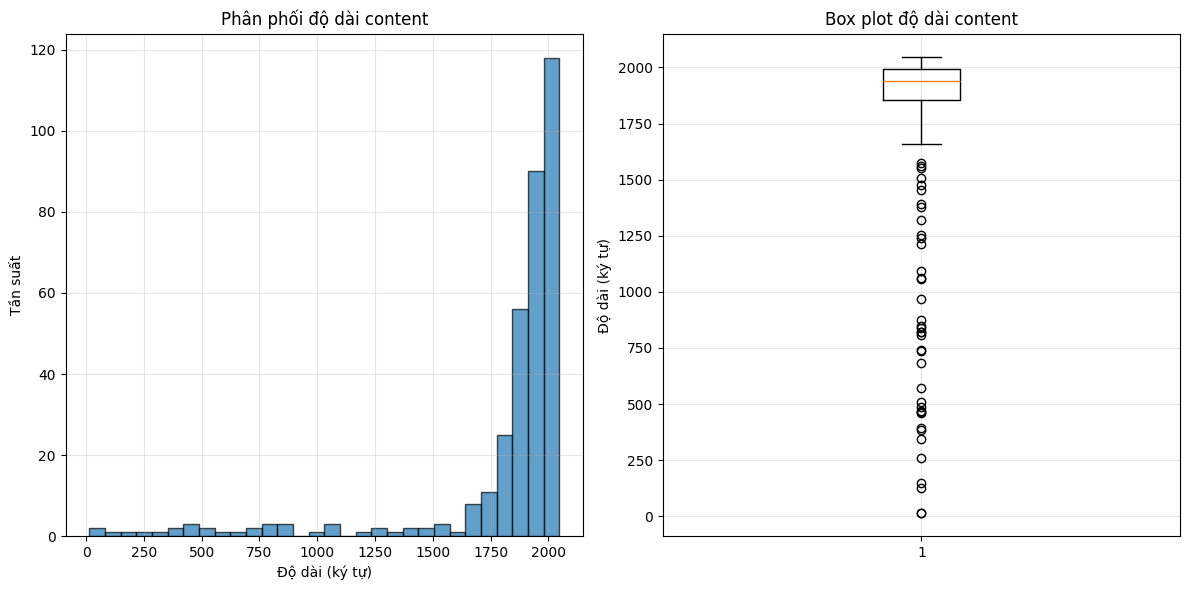


PHÂN TÍCH CHUNKING:
Số chunks có độ dài > 1000 ký tự: 323
Tỷ lệ: 93.08%


In [16]:
# Phân tích thống kê độ dài content
import matplotlib.pyplot as plt
import numpy as np

# Lấy độ dài content của mỗi chunk
content_lengths = [len(chunk['metadata']['content']) for chunk in dense_chunk]

print("THỐNG KÊ ĐỘ DÀI CONTENT:")
print(f"Tổng số chunks: {len(dense_chunk)}")
print(f"Độ dài trung bình: {np.mean(content_lengths):.2f} ký tự")
print(f"Độ dài ngắn nhất: {np.min(content_lengths)} ký tự")
print(f"Độ dài dài nhất: {np.max(content_lengths)} ký tự")
print(f"Độ lệch chuẩn: {np.std(content_lengths):.2f}")
print(f"Trung vị: {np.median(content_lengths):.2f}")

# Phân vị
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    print(f"Phân vị {p}%: {np.percentile(content_lengths, p):.2f}")

# Vẽ histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(content_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Phân phối độ dài content')
plt.xlabel('Độ dài (ký tự)')
plt.ylabel('Tần suất')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(content_lengths)
plt.title('Box plot độ dài content')
plt.ylabel('Độ dài (ký tự)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Đếm số chunk có độ dài > 1000 ký tự (cần chunking)
long_chunks = [length for length in content_lengths if length > 1000]
print(f"\nPHÂN TÍCH CHUNKING:")
print(f"Số chunks có độ dài > 1000 ký tự: {len(long_chunks)}")
print(f"Tỷ lệ: {len(long_chunks)/len(content_lengths)*100:.2f}%")

In [17]:
# # Khởi tạo embedding model
# embedding_model = SentenceTransformer("AITeamVN/Vietnamese_Embedding")
# embedding_model.max_seq_length = 2048
# print(f"Đã khởi tạo embedding model: {embedding_model.get_sentence_embedding_dimension()} dimensions")

In [18]:
def create_parent_document_chunks(parent_chunks, embedding_model, child_chunk_size=512, overlap=100):
    """
    Tạo child chunks từ parent chunks với embedding
    
    Args:
        parent_chunks: Danh sách parent chunks từ file Dense.json
        embedding_model: Model embedding để tạo vector cho child chunks
        child_chunk_size: Kích thước tối đa của mỗi child chunk (ký tự)
        overlap: Độ overlap giữa các child chunks
    
    Returns:
        child_chunks: Danh sách child chunks với embedding
    """
    child_chunks = []
    global_child_counter = 0  # Đảm bảo ID unique
    
    # Khởi tạo text splitter cho child chunks
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=child_chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""]
    )
    
    for parent_chunk in parent_chunks:
        parent_id = parent_chunk['id']
        content = parent_chunk['metadata']['content']
        
        # Chỉ chunk những parent có content dài > child_chunk_size
        if len(content) <= child_chunk_size:
            # Nếu parent đủ ngắn, giữ nguyên nhưng sử dụng global counter
            child_chunk = {
                "id": f"{parent_id}_child_{global_child_counter}",
                "values": embedding_model.encode(content).tolist(),
                "metadata": {
                    **parent_chunk['metadata'],  # Copy toàn bộ metadata từ parent
                    "parent_id": parent_id,
                    "child_index": 0
                }
            }
            child_chunks.append(child_chunk)
            global_child_counter += 1
        else:
            # Chunk content thành nhiều phần nhỏ
            sub_contents = splitter.split_text(content)
            
            for i, sub_content in enumerate(sub_contents):
                child_chunk = {
                    "id": f"{parent_id}_child_{global_child_counter}",
                    "values": embedding_model.encode(sub_content.strip()).tolist(),
                    "metadata": {
                        **parent_chunk['metadata'],  # Copy toàn bộ metadata từ parent
                        "content": sub_content.strip(),  # Override content với sub_content
                        "parent_id": parent_id,
                        "child_index": i,
                        "tokens": len(sub_content.strip())  # Update token count
                    }
                }
                child_chunks.append(child_chunk)
                global_child_counter += 1
    
    return child_chunks

In [19]:
# Phân tích chiến lược chunking tối ưu dựa trên thống kê
print("CHIẾN LƯỢC CHUNKING TỐI ƯU")
print("="*50)

# Phân tích dựa trên thống kê hiện tại
print("PHÂN TÍCH HIỆN TẠI:")
print(f"- 93% chunks cần chunking (>1000 ký tự)")
print(f"- Độ dài trung bình: 1813 ký tự")
print(f"- 75% chunks ≥ 1857 ký tự")
print(f"- Phần lớn chunks rất dài, cần chia nhỏ")

print("\nCHIẾN LƯỢC ĐỀ XUẤT:")
print("1. Child chunk size: 400-500 ký tự")
print("   → Lý do: Phù hợp với retrieval, không quá ngắn/dài")
print("2. Overlap: 50-80 ký tự") 
print("   → Lý do: Đảm bảo tính liên tục ngữ cảnh")
print("3. Dự kiến tăng từ 347 → ~1200-1500 child chunks")

# Ước tính kết quả với các chiến lược khác nhau
strategies = [
    {"name": "Conservative", "size": 600, "overlap": 100},
    {"name": "Balanced", "size": 450, "overlap": 75},
    {"name": "Aggressive", "size": 350, "overlap": 50}
]

print("\nSIMULATION CÁC CHIẾN LƯỢC:")
for strategy in strategies:
    # Ước tính số child chunks
    avg_parent_size = 1813
    child_size = strategy["size"]
    overlap = strategy["overlap"]
    
    # Công thức ước tính: ceil(parent_size / (child_size - overlap))
    import math
    estimated_children_per_parent = math.ceil(avg_parent_size / (child_size - overlap))
    total_estimated_children = estimated_children_per_parent * len(dense_chunk)
    
    print(f"\n{strategy['name']} Strategy:")
    print(f"  - Child size: {child_size} ký tự")
    print(f"  - Overlap: {overlap} ký tự")
    print(f"  - Ước tính children/parent: {estimated_children_per_parent}")
    print(f"  - Tổng child chunks: ~{total_estimated_children}")

print("\nKHUYẾN NGHỊ: Sử dụng Balanced Strategy (450 ký tự, overlap 75)")
print("   → Cân bằng giữa chất lượng retrieval và số lượng chunks")

CHIẾN LƯỢC CHUNKING TỐI ƯU
PHÂN TÍCH HIỆN TẠI:
- 93% chunks cần chunking (>1000 ký tự)
- Độ dài trung bình: 1813 ký tự
- 75% chunks ≥ 1857 ký tự
- Phần lớn chunks rất dài, cần chia nhỏ

CHIẾN LƯỢC ĐỀ XUẤT:
1. Child chunk size: 400-500 ký tự
   → Lý do: Phù hợp với retrieval, không quá ngắn/dài
2. Overlap: 50-80 ký tự
   → Lý do: Đảm bảo tính liên tục ngữ cảnh
3. Dự kiến tăng từ 347 → ~1200-1500 child chunks

SIMULATION CÁC CHIẾN LƯỢC:

Conservative Strategy:
  - Child size: 600 ký tự
  - Overlap: 100 ký tự
  - Ước tính children/parent: 4
  - Tổng child chunks: ~1388

Balanced Strategy:
  - Child size: 450 ký tự
  - Overlap: 75 ký tự
  - Ước tính children/parent: 5
  - Tổng child chunks: ~1735

Aggressive Strategy:
  - Child size: 350 ký tự
  - Overlap: 50 ký tự
  - Ước tính children/parent: 7
  - Tổng child chunks: ~2429

KHUYẾN NGHỊ: Sử dụng Balanced Strategy (450 ký tự, overlap 75)
   → Cân bằng giữa chất lượng retrieval và số lượng chunks


In [20]:
# Thực hiện Parent Document Chunking với chiến lược tối ưu
print("THỰC HIỆN CHUNKING VỚI CHIẾN LƯỢC TỐI ƯU")
print("="*50)

# Áp dụng Balanced Strategy: 450 ký tự, overlap 75
optimal_child_size = 450
optimal_overlap = 75

print(f"Tham số chunking:")
print(f"  - Child chunk size: {optimal_child_size} ký tự")
print(f"  - Overlap: {optimal_overlap} ký tự")
print(f"  - Separators: [\\n\\n, \\n, ., !, ?, ' ', '']")

# Tạo child chunks với tham số tối ưu
child_chunks_optimal = create_parent_document_chunks(
    parent_chunks=dense_chunk,
    embedding_model=embedding_model,
    child_chunk_size=optimal_child_size,
    overlap=optimal_overlap
)

print(f"\nKẾT QUẢ CHUNKING:")
print(f"  - Parent chunks: {len(dense_chunk)}")
print(f"  - Child chunks: {len(child_chunks_optimal)}")
print(f"  - Tỷ lệ tăng: {len(child_chunks_optimal)/len(dense_chunk):.1f}x")

# Thống kê chi tiết
child_lengths_optimal = [len(chunk['metadata']['content']) for chunk in child_chunks_optimal]
print(f"\nTHỐNG KÊ CHILD CHUNKS TỐI ƯU:")
print(f"  - Độ dài trung bình: {np.mean(child_lengths_optimal):.1f} ký tự")
print(f"  - Độ dài min: {np.min(child_lengths_optimal)} ký tự")
print(f"  - Độ dài max: {np.max(child_lengths_optimal)} ký tự")
print(f"  - Độ lệch chuẩn: {np.std(child_lengths_optimal):.1f}")

# Phân tích phân vị
percentiles = [25, 50, 75, 90, 95]
print(f"PHÂN VỊ CHILD CHUNKS:")
for p in percentiles:
    print(f"  - Phân vị {p}%: {np.percentile(child_lengths_optimal, p):.1f} ký tự")

# Kiểm tra chunks có vượt quá threshold không
over_threshold = [length for length in child_lengths_optimal if length > 500]
print(f"\nKIỂM TRA CHẤT LƯỢNG:")
print(f"  - Chunks > 500 ký tự: {len(over_threshold)} ({len(over_threshold)/len(child_chunks_optimal)*100:.1f}%)")
print(f"  - Chunks < 100 ký tự: {len([l for l in child_lengths_optimal if l < 100])} ({len([l for l in child_lengths_optimal if l < 100])/len(child_chunks_optimal)*100:.1f}%)")

# Sample một vài chunks
print(f"\n🔍 SAMPLE CHILD CHUNKS TỐI ƯU:")
for i in range(min(3, len(child_chunks_optimal))):
    chunk = child_chunks_optimal[i]
    content_preview = chunk['metadata']['content'][:80] + "..." if len(chunk['metadata']['content']) > 80 else chunk['metadata']['content']
    print(f"\nChild {i+1}:")
    print(f"  ID: {chunk['id']}")
    print(f"  Parent: {chunk['metadata']['parent_id']}")
    print(f"  Length: {len(chunk['metadata']['content'])} chars")
    print(f"  Content: {content_preview}")

print(f"\n🎯 CHUẨN BỊ LƯU FILE...")

THỰC HIỆN CHUNKING VỚI CHIẾN LƯỢC TỐI ƯU
Tham số chunking:
  - Child chunk size: 450 ký tự
  - Overlap: 75 ký tự
  - Separators: [\n\n, \n, ., !, ?, ' ', '']

KẾT QUẢ CHUNKING:
  - Parent chunks: 347
  - Child chunks: 1971
  - Tỷ lệ tăng: 5.7x

THỐNG KÊ CHILD CHUNKS TỐI ƯU:
  - Độ dài trung bình: 327.2 ký tự
  - Độ dài min: 1 ký tự
  - Độ dài max: 450 ký tự
  - Độ lệch chuẩn: 98.8
PHÂN VỊ CHILD CHUNKS:
  - Phân vị 25%: 264.0 ký tự
  - Phân vị 50%: 349.0 ký tự
  - Phân vị 75%: 409.0 ký tự
  - Phân vị 90%: 439.0 ký tự
  - Phân vị 95%: 447.0 ký tự

KIỂM TRA CHẤT LƯỢNG:
  - Chunks > 500 ký tự: 0 (0.0%)
  - Chunks < 100 ký tự: 41 (2.1%)

🔍 SAMPLE CHILD CHUNKS TỐI ƯU:

Child 1:
  ID: LSD_chunk_00000_child_0
  Parent: LSD_chunk_00000
  Length: 320 chars
  Content: Đảng Cộng sản Việt Nam do Chủ tịch Hồ Chí Minh sáng lập (3-2-1930). Từ thời điểm...

Child 2:
  ID: LSD_chunk_00000_child_1
  Parent: LSD_chunk_00000
  Length: 385 chars
  Content: . “Đảng Cộng sản Việt Nam là đội tiền phong của gia

✅ Đã lưu 1971 chunks vào: ./Lich_Su_Dang_Child_Dense_Optimal.json
ĐÃ LƯU THÀNH CÔNG!
File: ./Lich_Su_Dang_Child_Dense_Optimal.json
Số child chunks: 1971
Kích thước file: 58.55 MB


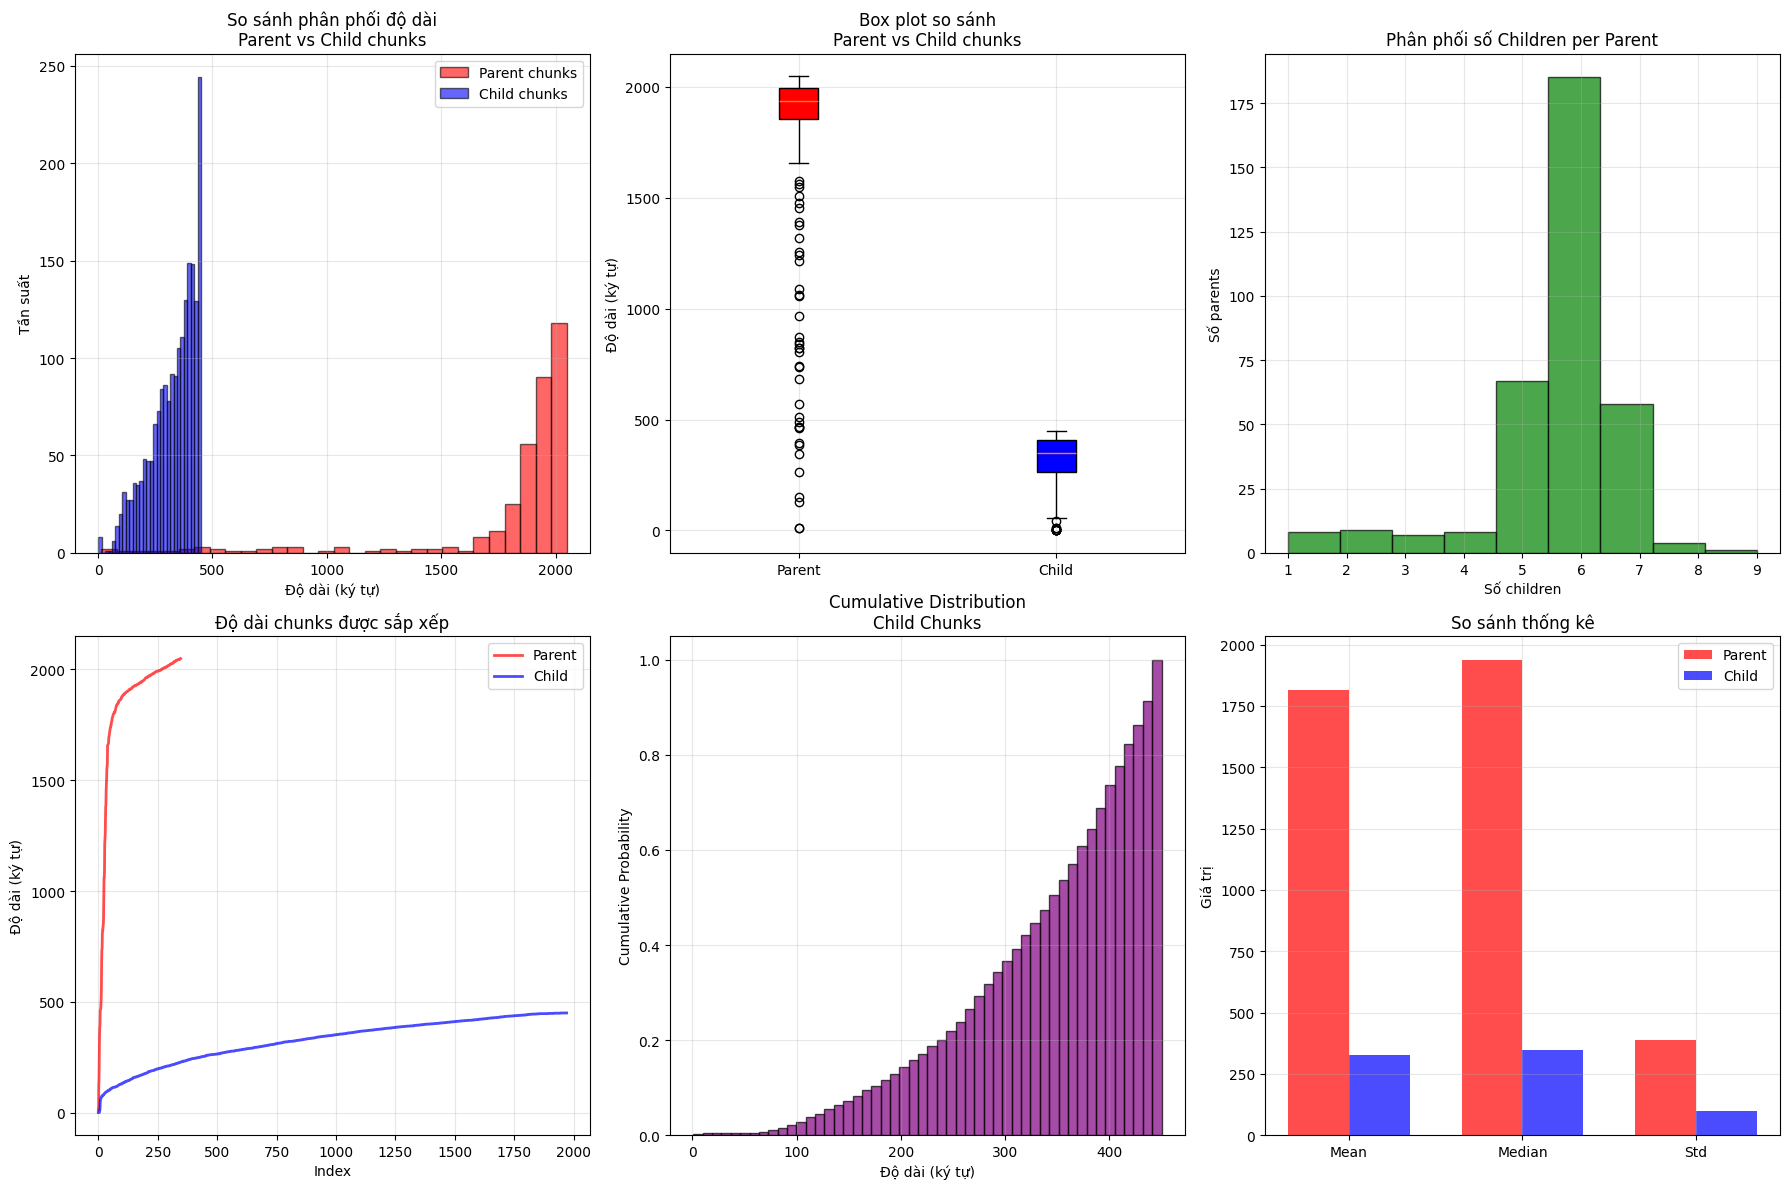


TÓM TẮT KẾT QUẢ PARENT DOCUMENT CHUNKING
HIỆU QUẢ CHUNKING:
  Tăng từ 347 → 1971 chunks (5.7x)
  Giảm độ dài trung bình: 1813 → 327 ký tự
  Tỷ lệ chunks < 500 ký tự: 100.0%
  Độ lệch chuẩn giảm: 387 → 99

OUTPUT FILES:
  Original dense chunks: ./Lich_Su_Dang_Dense_Global.json
  Child chunks (optimal): ./Lich_Su_Dang_Child_Dense_Optimal.json

SẴN SÀNG CHO PARENT DOCUMENT RETRIEVAL!
  Child chunks để tìm kiếm (high recall)
  Parent chunks để context (full information)
  Metadata đầy đủ cho filtering và ranking


In [21]:
# Lưu file child chunks tối ưu và visualization
optimal_output_file = "./Lich_Su_Dang_Child_Dense_Optimal.json"

try:
    save_chunks_to_json(child_chunks_optimal, optimal_output_file)
    print(f"ĐÃ LƯU THÀNH CÔNG!")
    print(f"File: {optimal_output_file}")
    print(f"Số child chunks: {len(child_chunks_optimal)}")
    
    # Kiểm tra file
    import os
    if os.path.exists(optimal_output_file):
        file_size = os.path.getsize(optimal_output_file) / (1024 * 1024)  # MB
        print(f"Kích thước file: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Lỗi khi lưu file: {e}")

# Comprehensive Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. So sánh phân phối độ dài trước/sau chunking
axes[0, 0].hist(content_lengths, bins=30, alpha=0.6, label='Parent chunks', color='red', edgecolor='black')
axes[0, 0].hist(child_lengths_optimal, bins=30, alpha=0.6, label='Child chunks', color='blue', edgecolor='black')
axes[0, 0].set_title('So sánh phân phối độ dài\nParent vs Child chunks')
axes[0, 0].set_xlabel('Độ dài (ký tự)')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot so sánh
data_to_plot = [content_lengths, child_lengths_optimal]
bp = axes[0, 1].boxplot(data_to_plot, labels=['Parent', 'Child'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][1].set_facecolor('blue')
axes[0, 1].set_title('Box plot so sánh\nParent vs Child chunks')
axes[0, 1].set_ylabel('Độ dài (ký tự)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Phân phối số children per parent
children_per_parent_optimal = {}
for chunk in child_chunks_optimal:
    parent_id = chunk['metadata']['parent_id']
    children_per_parent_optimal[parent_id] = children_per_parent_optimal.get(parent_id, 0) + 1

children_counts_optimal = list(children_per_parent_optimal.values())
axes[0, 2].hist(children_counts_optimal, bins=max(children_counts_optimal), alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_title('Phân phối số Children per Parent')
axes[0, 2].set_xlabel('Số children')
axes[0, 2].set_ylabel('Số parents')
axes[0, 2].grid(True, alpha=0.3)

# 4. Sorted lengths
axes[1, 0].plot(range(len(content_lengths)), sorted(content_lengths), 'r-', alpha=0.7, label='Parent', linewidth=2)
axes[1, 0].plot(range(len(child_lengths_optimal)), sorted(child_lengths_optimal), 'b-', alpha=0.7, label='Child', linewidth=2)
axes[1, 0].set_title('Độ dài chunks được sắp xếp')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Độ dài (ký tự)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Cumulative distribution
axes[1, 1].hist(child_lengths_optimal, bins=50, cumulative=True, density=True, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Cumulative Distribution\nChild Chunks')
axes[1, 1].set_xlabel('Độ dài (ký tự)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].grid(True, alpha=0.3)

# 6. Statistics comparison
stats_parent = [np.mean(content_lengths), np.median(content_lengths), np.std(content_lengths)]
stats_child = [np.mean(child_lengths_optimal), np.median(child_lengths_optimal), np.std(child_lengths_optimal)]
x_pos = np.arange(3)
width = 0.35

axes[1, 2].bar(x_pos - width/2, stats_parent, width, label='Parent', color='red', alpha=0.7)
axes[1, 2].bar(x_pos + width/2, stats_child, width, label='Child', color='blue', alpha=0.7)
axes[1, 2].set_title('So sánh thống kê')
axes[1, 2].set_ylabel('Giá trị')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['Mean', 'Median', 'Std'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print(f"\nTÓM TẮT KẾT QUẢ PARENT DOCUMENT CHUNKING")
print("="*60)
print(f"HIỆU QUẢ CHUNKING:")
print(f"  Tăng từ {len(dense_chunk)} → {len(child_chunks_optimal)} chunks ({len(child_chunks_optimal)/len(dense_chunk):.1f}x)")
print(f"  Giảm độ dài trung bình: {np.mean(content_lengths):.0f} → {np.mean(child_lengths_optimal):.0f} ký tự")
print(f"  Tỷ lệ chunks < 500 ký tự: {len([l for l in child_lengths_optimal if l <= 500])/len(child_chunks_optimal)*100:.1f}%")
print(f"  Độ lệch chuẩn giảm: {np.std(content_lengths):.0f} → {np.std(child_lengths_optimal):.0f}")

print(f"\nOUTPUT FILES:")
print(f"  Original dense chunks: ./Lich_Su_Dang_Dense_Global.json")
print(f"  Child chunks (optimal): {optimal_output_file}")

print(f"\nSẴN SÀNG CHO PARENT DOCUMENT RETRIEVAL!")
print(f"  Child chunks để tìm kiếm (high recall)")
print(f"  Parent chunks để context (full information)")
print(f"  Metadata đầy đủ cho filtering và ranking")